## 🧱 Concrete Crack Image Detection

Given *images of concrete surfaces*, let's try to detect **cracks** in the concrete.

We will be using a TensorFlow CNN neural network to make our predictions.

Data source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
positive_dir = Path('archive/Positive')
negative_dir = Path('archive/Negative')

### Creating DataFrames

In [9]:
list(positive_dir.glob(r'*.jpg'))

[WindowsPath('archive/Positive/00001.jpg'),
 WindowsPath('archive/Positive/00002.jpg'),
 WindowsPath('archive/Positive/00003.jpg'),
 WindowsPath('archive/Positive/00004.jpg'),
 WindowsPath('archive/Positive/00005.jpg'),
 WindowsPath('archive/Positive/00006.jpg'),
 WindowsPath('archive/Positive/00007.jpg'),
 WindowsPath('archive/Positive/00008.jpg'),
 WindowsPath('archive/Positive/00009.jpg'),
 WindowsPath('archive/Positive/00010.jpg'),
 WindowsPath('archive/Positive/00011.jpg'),
 WindowsPath('archive/Positive/00012.jpg'),
 WindowsPath('archive/Positive/00013.jpg'),
 WindowsPath('archive/Positive/00014.jpg'),
 WindowsPath('archive/Positive/00015.jpg'),
 WindowsPath('archive/Positive/00016.jpg'),
 WindowsPath('archive/Positive/00017.jpg'),
 WindowsPath('archive/Positive/00018.jpg'),
 WindowsPath('archive/Positive/00019.jpg'),
 WindowsPath('archive/Positive/00020.jpg'),
 WindowsPath('archive/Positive/00021.jpg'),
 WindowsPath('archive/Positive/00022.jpg'),
 WindowsPath('archive/Positive/0

In [10]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [13]:
positive_df = generate_df(positive_dir, label='POSITIVE')
negative_df = generate_df(negative_dir, label='NEGATIVE')

all_df = pd.concat([positive_df, negative_df], axis=0)

In [16]:
all_df = all_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,archive\Negative\09109.jpg,NEGATIVE
1,archive\Positive\11681_1.jpg,POSITIVE
2,archive\Negative\01233.jpg,NEGATIVE
3,archive\Negative\12374.jpg,NEGATIVE
4,archive\Negative\12888.jpg,NEGATIVE
...,...,...
39995,archive\Negative\13307.jpg,NEGATIVE
39996,archive\Negative\13106.jpg,NEGATIVE
39997,archive\Negative\15102.jpg,NEGATIVE
39998,archive\Positive\09388.jpg,POSITIVE


In [17]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [18]:
train_df

,Filepath,Label
30189,archive\Negative\11058.jpg,NEGATIVE
8931,archive\Negative\18664.jpg,NEGATIVE
29084,archive\Positive\17869_1.jpg,POSITIVE
29189,archive\Positive\03022.jpg,POSITIVE
2645,archive\Positive\05204.jpg,POSITIVE
...,...,...
2090,archive\Positive\13684_1.jpg,POSITIVE
35101,archive\Negative\09827.jpg,NEGATIVE
8720,archive\Positive\07154.jpg,POSITIVE
9955,archive\Negative\06924.jpg,NEGATIVE


In [19]:
test_df

,Filepath,Label
15731,archive\Negative\04840.jpg,NEGATIVE
34272,archive\Positive\05578.jpg,POSITIVE
39532,archive\Negative\15623.jpg,NEGATIVE
10818,archive\Negative\15814.jpg,NEGATIVE
35421,archive\Positive\13534_1.jpg,POSITIVE
...,...,...
7174,archive\Positive\15633_1.jpg,POSITIVE
27207,archive\Negative\10834.jpg,NEGATIVE
28566,archive\Negative\16823.jpg,NEGATIVE
20688,archive\Positive\17186_1.jpg,POSITIVE


### Loading Image Data

In [20]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [21]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [25]:
next(train_data)[1]

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

### Training

In [26]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

C:\Users\dukea_6wbfoy1\.conda\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 486ms/step - accuracy: 0.5673 - loss: 0.6799 - val_accuracy: 0.6179 - val_loss: 0.6627
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.7006 - loss: 0.6147 - val_accuracy: 0.6060 - val_loss: 0.5962
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7839 - loss: 0.5220 - val_accuracy: 0.8226 - val_loss: 0.4861
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8708 - loss: 0.4200 - val_accuracy: 0.9024 - val_loss: 0.4042
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9173 - loss: 0.3319 - val_accuracy: 0.9214 - val_loss: 0.3119
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9339 - loss: 0.2788 - val_accuracy: 0.9298 - val_loss: 0.2875
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9443 - loss: 0.2258 - val_accuracy: 0.9405 - val_loss: 0.2147
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9491 -

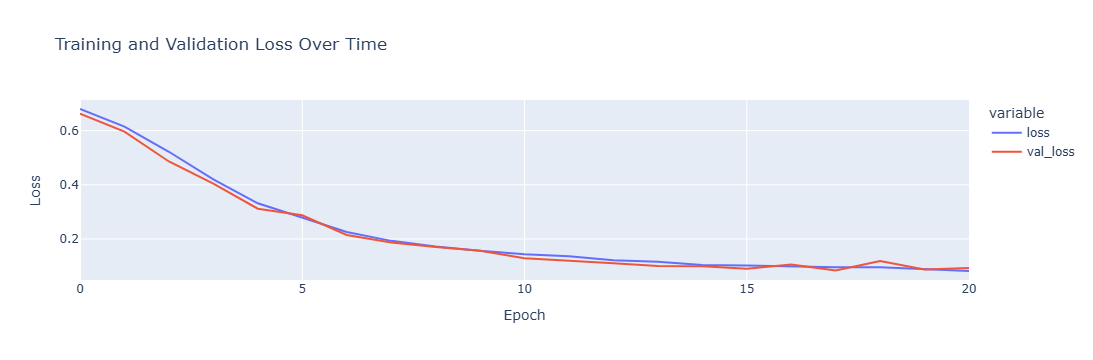

In [28]:
fig = px.line(
    history.history,
    y = ['loss', 'val_loss'],
    labels = {'index': 'Epoch', 'value': 'Loss'},
    title = "Training and Validation Loss Over Time"
)
fig.show()

### Results

In [33]:
np.squeeze((model.predict(test_data) >= 0.5).astype(int))

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


array([0, 1, 0, ..., 0, 1, 1])

In [30]:
test_data.labels

[0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,


In [37]:
def evaluate_model(model, test_data):
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=['NEGATIVE', 'POSITIVE'])

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2)+0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.yticks(ticks=np.arange(2)+0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n------------------------------------------\n", clr)

Test Loss: 0.08601
Test Accuracy: 97.06%
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


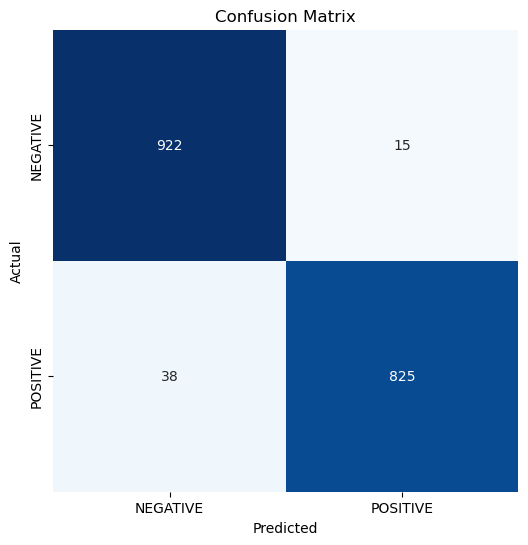

Classification Report:
------------------------------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.98      0.97       937
    POSITIVE       0.98      0.96      0.97       863

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [38]:
evaluate_model(model, test_data)